## Qualitative Model Comparison with Saliency

This example demonstrates the use of `xaitk-saliency` to qualitatively compare two different models using saliency maps.
The models we compare here both perform object detection and are trained on the [Visdrone dataset](http://aiskyeye.com/).
The first is [CenterNet](https://arxiv.org/pdf/1904.07850.pdf) using a ResNet50 backbone and the second is a modified version of YOLOv5 called [TPH-YOLOv5](https://arxiv.org/pdf/2108.11539.pdf).

We use the high-level `GenerateObjectDetectorBlackboxSaliency` interface to generate visual saliency for reference predictions made by each of our detectors.

<br>

To run this notebook in Colab, use the link below:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/XAITK/xaitk-saliency/blob/master/examples/ModelComparisonWithSaliency.ipynb)

## Setup Environment

Here we install `xaitk-saliency` and the "centernet" extra for `smqtk-detection` which includes the dependencies for the PyTorch-based `CenterNetVisdrone` class.

**Note for Colab users**: after setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/XAITK/xaitk-saliency/blob/master/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
import logging

logging.basicConfig(level=logging.WARNING)

import sys  # noqa

!{sys.executable} -m pip install -qU pip
print("Installing xaitk-saliency...")
!{sys.executable} -m pip install -q git+https://github.com/xaitk/xaitk-saliency.git
print("Installing smqtk-detection...")
!{sys.executable} -m pip install -qU smqtk-detection[centernet]
# Remove opencv-python, which requires libGL, which we don't require here, and replace with opencv-python-headless
print("Installing headless OpenCV...")
!{sys.executable} -m pip uninstall -qy opencv-python opencv-python-headless  # make sure they're both gone.
!{sys.executable} -m pip install -q opencv-python-headless
print("Done!")

Installing xaitk-saliency...
Installing smqtk-detection...
Installing headless OpenCV...
Done!


## Download Image File and Visualize

We are using a single example image from the VisDrone test dataset.
This image contains several classes and is dense in nature, providing several reference detections.

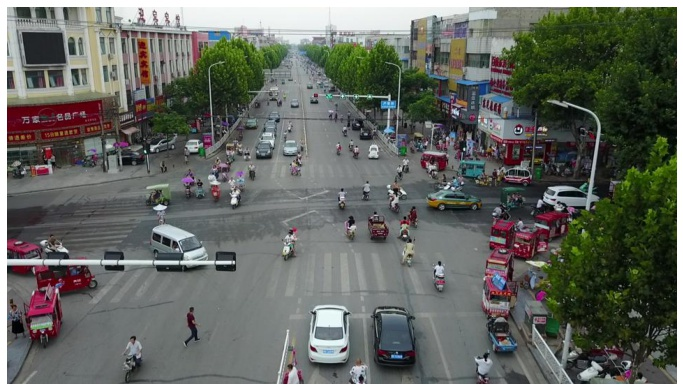

In [2]:
# Use JPEG format for inline visualizations
%config InlineBackend.figure_format = "jpeg"
%matplotlib inline

import os
import urllib
from collections.abc import Any, Sequence

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

data_dir = "./data"

os.makedirs(data_dir, exist_ok=True)

img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    _ = urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download", img_path)

img = np.asarray(Image.open(img_path))

plt.figure(figsize=(12, 12))
plt.axis("off")
_ = plt.imshow(img)

## TPH-YOLOv5 Detector
### Clone Repository

We will clone the TPH-YOLOv5 implementation from the author's github page and add the destination directory to our system path.
This will allow us to use the tools and models that are contained in the repository for this example.
In general, this is poor practice, but we are doing it here for the sake of this self-enclosed example.

In lieu of installing all of the requirements for the repository, we will install just the ones required for the tools that we will use.
This is a subset of the repository's `requirements.txt`.

In [3]:
dest = "./data/tph-yolov5"

if not os.path.isdir(dest):
    !git clone -q https://github.com/cv516Buaa/tph-yolov5.git {dest}

print("Installing needed requirements...")
# torch 1.11 has compatability issues
!{sys.executable} -m pip -q install "torch<1.11"
!{sys.executable} -m pip -q install "torchvision<0.12"
!{sys.executable} -m pip -q install tqdm
!{sys.executable} -m pip -q install seaborn
print("Done!")

sys.path.insert(1, dest)

Installing needed requirements...
Done!


### DetectImageObjects Implementation

To use the TPH-YOLOv5 model with the `GenerateObjectDetectorBlackboxSaliency` interface, we need to create an implementation of `DetectImageObjects` that wraps the underlying model.
The core method that requires implementation is `detect_objects()` which takes images and outputs predictions for each image in the format defined by the interface.

In [4]:
# imports from TPH-YOLOv5 github repo
import time
from collections.abc import Hashable, Iterable

import numpy as np
import torch
from models.experimental import attempt_load

# smqtk imports
from smqtk_detection import DetectImageObjects
from smqtk_detection.utils.bbox import AxisAlignedBoundingBox
from torch.utils.data import DataLoader, Dataset
from utils.augmentations import letterbox
from utils.general import non_max_suppression, scale_coords


class YOLOVisdrone(DetectImageObjects):
    """DetectImageObjects implementation using YOLOVisdrone"""

    def __init__(
        self,
        weights: str,
        img_size: tuple[int, int] = (640, 640),
        batch_size: int = 1,
        conf_thresh: float = 0.5,
        iou_thresh: float = 0.5,
        use_cuda: bool = False,
        num_workers: int = 4,
        log_interval: int = None,
    ) -> None:
        """
        img_size: size of image input to model
        batch_size: number of images to input as once
        conf_thresh: confidence threshold for detection results
        iou_thresh: IOU threshold for NMS
        use_cuda: use CUDA device to compute detections
        num_workers: number of worker processes to use for data loading
        log_interval: interval in batches to log messages during
        """

        self.img_size = np.array(img_size)

        if use_cuda:
            self.device = torch.device("cuda:0")
        else:
            self.device = torch.device("cpu")

        self.model = attempt_load(weights).to(self.device)
        self.model = self.model.eval()

        self.conf_thresh = conf_thresh
        self.iou_thresh = iou_thresh

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.log_interval = log_interval

        with torch.no_grad():
            _ = self.model(torch.zeros(1, 3, *self.img_size).to(self.device))  # warm up

    def detect_objects(
        self,
        img_iter: Iterable[np.ndarray],
    ) -> Iterable[Iterable[tuple[AxisAlignedBoundingBox, dict[Hashable, float]]]]:
        """Generate detections for input images"""
        # pytorch DataLoader for passed images
        dataset = DataLoader(
            PytorchDataset(
                img_iter,
                img_size=self.img_size,
            ),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

        # list of AxisAlignedBoundingBox detections to return
        preds = []
        for i, (img_batch, hs, ws) in enumerate(dataset):
            if self.log_interval is not None and (i + 1) % self.log_interval == 0:
                logging.info(f"[{i+1}/{len(dataset)}]")

            # load batch and normalize
            img_batch = img_batch.to(self.device)
            img_batch = img_batch.float()
            img_batch /= 255

            # pass through model
            with torch.no_grad():
                pred_batch = self.model(img_batch)[0]

            # perform NMS and scale detections to original image dimensions
            for img_pred, h, w in zip(pred_batch, hs, ws):
                img_pred = non_max_suppression(img_pred[None], conf_thres=self.conf_thresh, iou_thres=self.iou_thresh)[
                    0
                ]
                img_pred[:, :4] = scale_coords(img_batch.shape[2:], img_pred[:, :4], (h, w))
                img_pred = img_pred.cpu().numpy()

                preds.append(pred_mat_to_list(img_pred))

        return preds

    def get_config(self) -> dict[str, Any]:
        """Requried by interface"""
        return {}


class PytorchDataset(Dataset):
    """
    pyTorch DataLoader for images. Resizes image to model input size and
    returns original height and width as well.
    """

    def __init__(self, imgs: Sequence[np.ndarray], img_size: tuple[int, int] = None) -> None:
        """Intialize dataloader"""
        if img_size is None:
            img_size = [640, 640]
        self.imgs = list(imgs)
        self.img_size = img_size

    def __getitem__(self, idx: int) -> tuple[np.ndarray, int, int]:
        """Return a tuple of the image, image height, and image width"""
        img = self.imgs[idx]
        h = img.shape[0]
        w = img.shape[1]

        img = letterbox(img, new_shape=self.img_size, auto=True)[0]
        img = img.transpose((2, 0, 1))
        img = np.ascontiguousarray(img)

        return img, h, w

    def __len__(self) -> int:
        """Return the number of imgs"""
        return len(self.imgs)


def pred_mat_to_list(preds: Sequence[np.ndarray]) -> Sequence[AxisAlignedBoundingBox]:
    """Convert prediction matrix model output to AxisAlignedBoundingBox format."""
    pred_list = []

    for pred in preds:
        bbox = AxisAlignedBoundingBox(pred[0:2], pred[2:4])

        score_dict = dict.fromkeys(range(1, 11), 0)
        score_dict[pred[5] + 1] = pred[4]

        pred_list.append((bbox, score_dict))

    return pred_list

/home/local/KHQ/elim.schenck/anaconda3/envs/test/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Instantiate Detector Object

Now we will instantiate our YOLO detector object using the `YOLOVisdrone` class we just declared.
We use an input size of `1536x1536`, confidence threshold of `0.1`, and a IOU threshold of `0.5`.
Setting `use_cuda` to `True` here will decrease computation time if you have a CUDA device available.

In [5]:
# download weights
model_file = os.path.join(data_dir, "tph-yolov5.pth")
if not os.path.isfile(model_file):
    urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623880d04acac99f429fe3bf/download", model_file)

yolo_detector = YOLOVisdrone(
    weights=model_file,
    img_size=(1536, 1536),
    batch_size=1,
    use_cuda=False,
    num_workers=8,
    conf_thresh=0.1,
    iou_thresh=0.5,
    log_interval=1,
)

## CenterNet Detector

The `SMQTK-Detection` package provides the `CenterNetVisdrone` class, a `DetectImageObjects` implementation wrapping a PyTorch version of CenterNet.
It allows us to choose from a selection of different backend architectures, from which we will choose ResNet50.

Again, setting `use_cuda` to `True` here will accelerate saliency computation for this model.

In [6]:
import urllib

from smqtk_detection.impls.detect_image_objects.centernet import CenterNetVisdrone

# download weights
model_file = os.path.join(data_dir, "centernet-resnet50.pth")
if not os.path.isfile(model_file):
    urllib.request.urlretrieve("https://data.kitware.com/api/v1/item/623259f64acac99f426f21db/download", model_file)

centernet_detector = CenterNetVisdrone(
    arch="resnet50",
    model_file="data/centernet-resnet50.pth",
    max_dets=500,
    use_cuda=False,
    batch_size=1,
    num_workers=1,
)

## Get Image Predictions

We will pass our image through both of our models to obtain predictions to potentially generate saliency for.

Getting TPH-YOLOv5 image predictions...
Done in 0.79s
Getting CenterNet image predictions...
Done in 1.54s


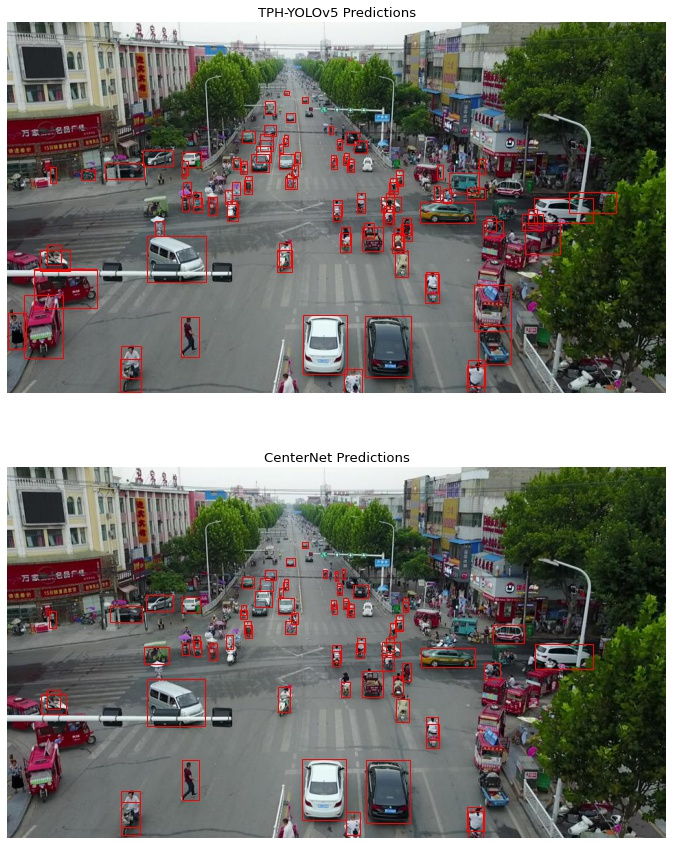

In [7]:
from matplotlib.patches import Rectangle

print("Getting TPH-YOLOv5 image predictions...")
start = time.time()
yolo_dets = yolo_detector([img])[0]
end = time.time()
print(f"Done in {end-start:.2f}s")

print("Getting CenterNet image predictions...")
start = time.time()
centernet_dets = centernet_detector([img])[0]
end = time.time()
print(f"Done in {end-start:.2f}s")

CLASS_NAMES = ["pedestrian", "people", "bicycle", "car", "van", "truck", "tricycle", "awning-tricycle", "bus", "motor"]


def show_dets(ax: plt.axes.Axes, dets: np.ndarray, thresh: float = 0.5, show_labels: bool = False) -> None:
    """Helper function to visualize detections"""
    for _i, det in enumerate(dets):
        score_dict = det[1]
        cls_idx = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_idx]

        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor="r", facecolor="none"))

            if show_labels:
                label = f"{CLASS_NAMES[cls_idx-1]} {conf:.2f}"
                ax.text(x1, y1 - 2, label, color="b", fontsize=8)


fig, axs = plt.subplots(2, 1, figsize=(15, 15))

axs[0].set_title("TPH-YOLOv5 Predictions")
axs[0].imshow(img)
axs[0].axis("off")
show_dets(axs[0], yolo_dets, thresh=0.4)

axs[1].set_title("CenterNet Predictions")
axs[1].imshow(img)
axs[1].axis("off")
show_dets(axs[1], centernet_dets, thresh=0.4)

## Select Reference Detections

For the sake of this example, we have pre-selected four reference detections from the predictions made by each of our models to compute saliency for.
We chose predictions that were made by both models (based on localization) so that we can compare their differences given a common reference.
These are displayed below.

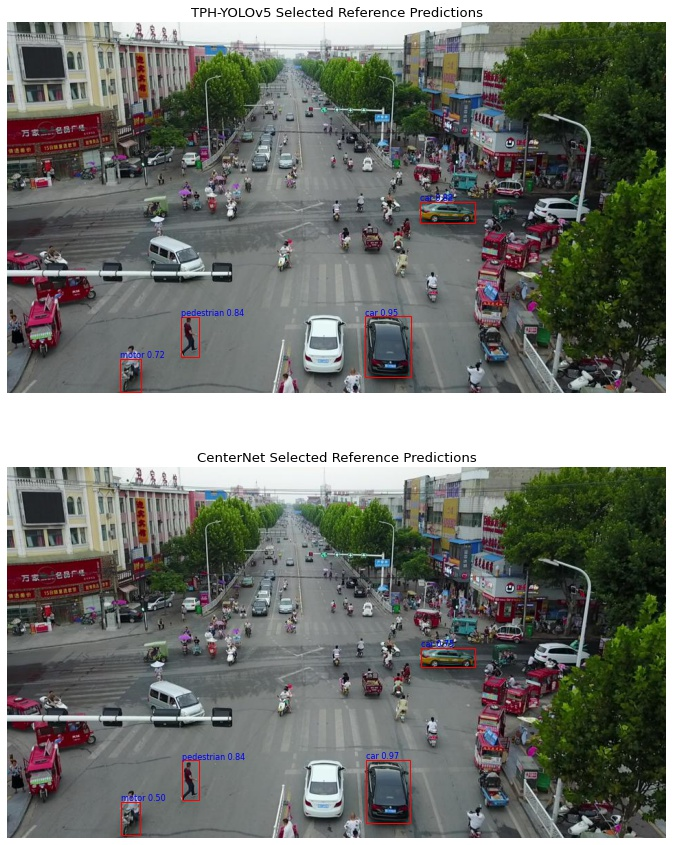

In [8]:
# indices of reference detections
yolo_idxs = [9, 0, 18, 4]
centernet_idxs = [2, 0, 33, 3]

yolo_ref_dets = [yolo_dets[idx] for idx in yolo_idxs]
centernet_ref_dets = [centernet_dets[idx] for idx in centernet_idxs]

fig, axs = plt.subplots(2, 1, figsize=(15, 15))

axs[0].set_title("TPH-YOLOv5 Selected Reference Predictions")
axs[0].imshow(img)
axs[0].axis("off")
show_dets(axs[0], yolo_ref_dets, thresh=0.4, show_labels=True)

axs[1].set_title("CenterNet Selected Reference Predictions")
axs[1].imshow(img)
axs[1].axis("off")
show_dets(axs[1], centernet_ref_dets, thresh=0.4, show_labels=True)

## Prepare Inputs

The `GenerateObjectDetectorBlackboxSaliency` interface requires our reference detections to be split into separate bounding boxes and scores inputs, both as numpy arrays.

In [9]:
def dets_to_mats(dets: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Convert array of detections to score and bbox matricies"""
    # use labels from first prediction to access all of them in a constant order
    labels = list(dets[0][1].keys())

    bboxes = np.empty((0, 4))
    scores = np.empty((0, 10))
    for det in dets:
        bbox = det[0]

        bboxes = np.vstack(
            (
                bboxes,
                [
                    *bbox.min_vertex,
                    *bbox.max_vertex,
                ],
            ),
        )

        score_dict = det[1]
        score_array = [score_dict[label] for label in labels]

        scores = np.vstack(
            (
                scores,
                score_array,
            ),
        )

    return bboxes, scores


yolo_bboxes, yolo_scores = dets_to_mats(yolo_ref_dets)
centernet_bboxes, centernet_scores = dets_to_mats(centernet_ref_dets)

## Generate Saliency
### Saliency Generation Object

We will use the `RandomGridStack` implementation to generate our saliency maps.
This implementation is very similar to the DRISEStack algorithm, but allows us to define the granularity of our saliency maps in pixels whereas DRISEStack uses rigid square-grids that are deformed to cover an input image which results in less control in the shape of masked regions.
For fine granularity, we use a small grid-cell size of 7x7 pixels.

To generate saliency maps that are localized and with minimal noise, we need to use a large number of occlusion masks.
We use 1200 masks here.

Due to the small cell size, we need to use a higher `p1` value to ensure that enough of the image is showing to detect any objects at all.

We also use set the saliency generator to use a gray fill to increase saliency map quality.
This fill represents the average channel intensities of the VisDrone dataset.

In [10]:
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import RandomGridStack

sal_generator = RandomGridStack(
    n=1200,  # number of masks
    s=(7, 7),  # occlusion grid cell size in pixels
    p1=0.7,  # probability of not occluding cell
    threads=8,  # execution threads
    seed=42,  # seed for replicable results
)

# gray average of VisDrone
fill = [95, 96, 93]
sal_generator.fill = fill

### TPH-YOLOv5

In [11]:
print("Generating TPH-YOLOv5 saliency maps...")
start = time.time()
yolo_sal_maps = sal_generator(img, yolo_bboxes, yolo_scores, yolo_detector)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating TPH-YOLOv5 saliency maps...
Done in 468.59s


### CenterNet

In [12]:
print("Generating CenterNet saliency maps...")
start = time.time()
centernet_sal_maps = sal_generator(img, centernet_bboxes, centernet_scores, centernet_detector)
end = time.time()
print(f"Done in {end-start:.2f}s")

Generating CenterNet saliency maps...
Done in 1147.01s


## Compare Saliency

Plotting the parallel saliency maps next to each other allows us to easily compare them.
We show the results for the TPH-YOLOv5 in the first row, and for CenterNet in the second row.

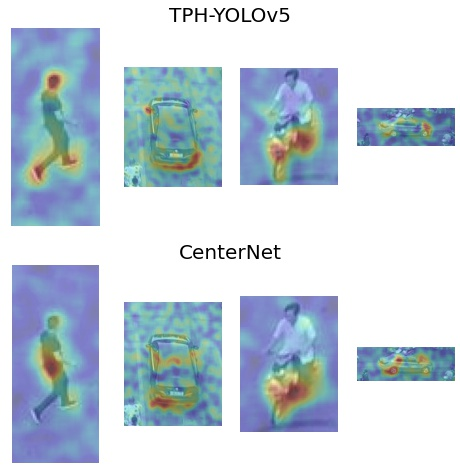

In [13]:
%matplotlib inline

gray_img = np.asarray(Image.fromarray(img).convert("L"))
pad_perc = 0.4

n = max(len(yolo_sal_maps), len(centernet_sal_maps))

fig, axs = plt.subplots(2, n, figsize=(8, 8))

for i, ax in enumerate(axs[0]):
    try:
        sal_map = yolo_sal_maps[i]
    except IndexError:
        ax.axis("off")
        continue

    x1, y1, x2, y2 = yolo_bboxes[i]
    pad_x = pad_perc * (x2 - x1)
    pad_y = pad_perc * (y2 - y1)
    x1 = max(int(x1 - pad_x), 0)
    y1 = max(int(y1 - pad_y), 0)
    x2 = int(x2 + pad_x)
    y2 = int(y2 + pad_y)

    img_crop = gray_img[y1 : (y2 + 1), x1 : (x2 + 1)]
    sal_crop = sal_map[y1 : (y2 + 1), x1 : (x2 + 1)]

    ax.imshow(img_crop, alpha=0.7, cmap="gray")
    ax.imshow(sal_crop, alpha=0.3, cmap="jet")
    ax.axis("off")

for i, ax in enumerate(axs[1]):
    try:
        sal_map = centernet_sal_maps[i]
    except IndexError:
        ax.axis("off")
        continue

    x1, y1, x2, y2 = centernet_bboxes[i]
    pad_x = pad_perc * (x2 - x1)
    pad_y = pad_perc * (y2 - y1)
    x1 = max(int(x1 - pad_x), 0)
    y1 = max(int(y1 - pad_y), 0)
    x2 = int(x2 + pad_x)
    y2 = int(y2 + pad_y)

    img_crop = gray_img[y1 : (y2 + 1), x1 : (x2 + 1)]
    sal_crop = sal_map[y1 : (y2 + 1), x1 : (x2 + 1)]

    ax.imshow(img_crop, alpha=0.7, cmap="gray")
    ax.imshow(sal_crop, alpha=0.3, cmap="jet")
    ax.axis("off")

axs = fig.subplots(2, 1)
axs[0].set_title("TPH-YOLOv5", fontsize=20)
axs[0].axis("off")
axs[1].set_title("CenterNet", fontsize=20)
_ = axs[1].axis("off")